<a href="https://colab.research.google.com/github/iamviji/project/blob/master/PostMidTerm/ref/py_itpp_py_radio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/iamviji/py-itpp.git
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .  
!cd py-itpp; ls ; pip3 install -e .  
!cat py-itpp/setup.py
import sys
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp # import itpp is not working, after this hack i started to work
sys.path.append('./py-itpp/lib')
#!pip install gwpy &> /dev/null

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  automake autotools-dev libsigsegv2 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc libtool gettext m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev libsigsegv2 m4
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 1,082 kB of archives.
After this operation, 3,994 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsigsegv2 amd64 2.12-1 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 m4 amd64 1.4.18-1 [197 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 autoconf all 2.69-11 [322 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/main amd64 automake all 1:1.15.1-3ubuntu2 [509 kB]
Fet

In [8]:
import itpp
from matplotlib import pyplot as plt

In [9]:
# File:   hamming.py
# Brief:  Simulates a Hamming coded radio link over AWGN channel
# Author: Vidit Saxena
#
# Usage:  import hamming
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

#import itpp

def block_error_ratio_hamming_awgn(snr_db, block_size):
    
    mapping_k_m = {4: 3} # Mapping from k (block size) to m. m = 3 implies (7,4) code
    m = mapping_k_m[block_size]
     
    '''Hamming encoder and decoder instance'''
    hamm = itpp.comm.Hamming_Code(m)
    n = pow(2,m) - 1 # channel use
    rate = float(block_size)/float(n)
    
    '''Generate random bits'''
    nrof_bits = 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    
    '''Encode the bits'''
    encoded_bits = hamm.encode(source_bits)
    
    '''Modulate the bits'''
    modulator_ = itpp.comm.modulator_2d()
    constellation = itpp.cvec('-1+0i, 1+0i')
    symbols = itpp.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(encoded_bits)
    
    '''Add the effect of channel to the signal'''
    #rate = 1.0 # VIJAYA_MODIFY
    noise_variance = 1.0 / (rate * pow(10, 0.1 * snr_db))
    print ("block_error_ratio_hamming_awgn:noise_var:", noise_variance, " ", snr_db)
    noise = itpp.randn_c(tx_signal.length())
    noise *= itpp.math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Decode the received bits'''
    decoded_bits = hamm.decode(demodulated_bits) 
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, decoded_bits)
    return blerc.get_errorrate()

In [10]:
# File:   uncoded.py
# Brief:  Simulates uncoded link over AWGN channel 
# Author: Vidit Saxena
#
# Usage:  import uncoded
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------



def block_error_ratio_uncoded_awgn(snr_db, block_size):
    '''Generate random bits'''
    nrof_bits = 3 * 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    rate = 1.0
    
    '''Modulate the bits'''
    modulator_ = itpp.comm.modulator_2d()
    constellation = itpp.cvec('-1+0i, 1+0i')
    symbols = itpp.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    noise_variance = 1.0 / (rate * pow(10, 0.1 * snr_db))
    print ("block_error_ratio_uncoded_awgn:noise_var:",noise_variance, " ", snr_db)
    noise = itpp.randn_c(tx_signal.length())
    noise *= itpp.math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, demodulated_bits)
    return blerc.get_errorrate()

In [11]:
# File:   autoencoder.py
# Brief:  Neural network autoencoded radio link over AWGN channel 
# Author: Vidit Saxena
#
# Usage:  import autoencoder
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

import tensorflow as tf
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

def block_error_ratio_autoencoder_awgn(snrs_db, block_size, channel_use, batch_size, nrof_steps):
    
    print('block_size %d'%(block_size))
    print('channel_use %d'%(channel_use))
    
    rate = float(block_size)/float(channel_use)
    print('rate %0.2f'%(rate))
    
    '''The input is one-hot encoded vector for each codeword'''
    alphabet_size = pow(2, block_size)
    alphabet = np.eye(alphabet_size, dtype = 'float32') # One-hot encoded values
    
    '''Repeat the alphabet to create training and test datasets'''
    train_dataset = np.transpose(np.tile(alphabet, int(batch_size)))
    test_dataset = np.transpose(np.tile(alphabet, int(batch_size * 1000)))
    
    print('--Setting up autoencoder graph--')
    input, output, noise_std_dev, h_norm = _implement_autoencoder(alphabet_size, channel_use)
    
    print( '--Setting up training scheme--')
    train_step = _implement_training(output, input)
    
    print('--Setting up accuracy--')
    accuracy = _implement_accuracy(output, input)

    print('--Starting the tensorflow session--')
    sess = _setup_interactive_tf_session()
    _init_and_start_tf_session(sess)
    
    print('--Training the autoencoder over awgn channel--')
    _train(train_step, input, noise_std_dev, nrof_steps, train_dataset, snrs_db, rate, accuracy)
    
    print('--Evaluating autoencoder performance--')
    bler = _evaluate(input, noise_std_dev, test_dataset, snrs_db, rate, accuracy)
    
    print('--Closing the session--')
    _close_tf_session(sess)
    
    return bler
    
def _setup_tf_session():
    return tf.Session()

def _setup_interactive_tf_session():
    return tf.compat.v1.InteractiveSession()

def _init_and_start_tf_session():
    init = tf.compat.v1.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    return sess

def _init_and_start_tf_session(sess):
    sess.run(tf.compat.v1.global_variables_initializer())
    
def _close_tf_session(sess):
    sess.close
    
def _weight_variable(shape):
    initial = tf.random.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def _bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

def _implement_autoencoder(input_dimension, encoder_dimension):
    input = tf.compat.v1.placeholder(tf.float32, [None, input_dimension])
    
    '''Densely connected encoder layer'''
    W_enc1 = _weight_variable([input_dimension, input_dimension])
    b_enc1 = _bias_variable([input_dimension])
    
    h_enc1 = tf.nn.relu(tf.matmul(input, W_enc1) + b_enc1)
    
    '''Densely connected encoder layer'''
    W_enc2 = _weight_variable([input_dimension, encoder_dimension])
    b_enc2 = _bias_variable([encoder_dimension])
    
    h_enc2 = tf.matmul(h_enc1, W_enc2) + b_enc2
    
    '''Normalization layer'''
    normalization_factor = tf.math.reciprocal(tf.sqrt(tf.reduce_sum(tf.square(h_enc2), 1))) * np.sqrt(encoder_dimension)
    h_norm = tf.multiply(tf.tile(tf.expand_dims(normalization_factor, 1), [1, encoder_dimension]), h_enc2)

    '''AWGN noise layer'''
    noise_std_dev = tf.compat.v1.placeholder(tf.float32)
    channel = tf.random.normal(tf.shape(h_norm), stddev=noise_std_dev)
    h_noisy = tf.add(h_norm, channel)
    
    '''Densely connected decoder layer'''
    W_dec1 = _weight_variable([encoder_dimension, input_dimension])
    b_dec1 = _bias_variable([input_dimension])
    
    h_dec1 = tf.nn.relu(tf.matmul(h_noisy, W_dec1) + b_dec1)
        
    '''Output layer'''
    W_out = _weight_variable([input_dimension, input_dimension])
    b_out = _bias_variable([input_dimension])
     
    output = tf.nn.softmax(tf.matmul(h_dec1, W_out) + b_out)
    
    return (input, output, noise_std_dev, h_norm)
    
def _implement_training(output, input):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = output, labels = input))
    
#     train_step = tf.train.GradientDescentOptimizer(1e-2).minimize(cross_entropy) 
    train_step = tf.compat.v1.train.AdamOptimizer(1e-3).minimize(cross_entropy)
    
    return train_step

def _implement_accuracy(output, input):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(input, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

def _train(train_step, input, noise_std_dev, nrof_steps, training_dataset, snrs_db, rate, accuracy):
    print('--Training--')
    print('number of steps %d'%(nrof_steps))
    snr = max(snrs_db)
    snrs_rev = snrs_db[::-1]
    for snr in snrs_rev[0:1]: # Train with higher SNRs first
        print('training snr %0.2f db'%(snr))
        noise = np.sqrt(1.0 / (2 * rate * pow(10, 0.1 * snr)))
        #noise = np.sqrt(1.0 / ( pow(10, 0.1 * snr))) # VIJAYA_MODIFY
        print ("_train:noise_var:", noise, " ", snr)

        for i in range(int(nrof_steps)):
            batch = training_dataset
            np.random.shuffle(batch)
            if (i + 1) % (nrof_steps/10) == 0: # i = 0 is the first step
                print('training step %d'%(i + 1))
            train_step.run(feed_dict={input: batch, noise_std_dev: noise})
        print('training accuracy %0.4f'%(accuracy.eval(feed_dict={input: batch, noise_std_dev: noise})))

def _evaluate(input, noise_std_dev, test_dataset, snrs_db, rate, accuracy):
    print('--Evaluating NN performance on test dataset--')
    bler = []
    for snr in snrs_db:
        noise = np.sqrt(1.0 / (2 * rate * pow(10, 0.1 * snr)))
        print ("_evaluate:noise_var:", noise, " ", snr)
        acc = accuracy.eval(feed_dict={input: test_dataset, noise_std_dev: noise})
        bler.append(1.0 - acc)
    return bler

-------Evaluating BLER for Uncoded (4,4) over AWGN-------
block_error_ratio_uncoded_awgn:noise_var: 2.5118864315095806   -4
block_error_ratio_uncoded_awgn:noise_var: 1.9952623149688797   -3
block_error_ratio_uncoded_awgn:noise_var: 1.5848931924611134   -2
block_error_ratio_uncoded_awgn:noise_var: 1.2589254117941673   -1
block_error_ratio_uncoded_awgn:noise_var: 1.0   0
block_error_ratio_uncoded_awgn:noise_var: 0.7943282347242815   1
block_error_ratio_uncoded_awgn:noise_var: 0.6309573444801932   2
block_error_ratio_uncoded_awgn:noise_var: 0.5011872336272722   3
block_error_ratio_uncoded_awgn:noise_var: 0.39810717055349726   4
block_error_ratio_uncoded_awgn:noise_var: 0.31622776601683794   5
block_error_ratio_uncoded_awgn:noise_var: 0.25118864315095796   6
block_error_ratio_uncoded_awgn:noise_var: 0.19952623149688792   7
block_error_ratio_uncoded_awgn:noise_var: 0.15848931924611132   8
-------Evaluating BLER for Hamming (7,4) over AWGN-------
block_error_ratio_hamming_awgn:noise_var: 4.3

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


training step 5000
training step 10000
training step 15000
training step 20000
training step 25000
training step 30000
training step 35000
training step 40000
training step 45000
training step 50000
training accuracy 1.0000
--Evaluating autoencoder performance--
--Evaluating NN performance on test dataset--
_evaluate:noise_var: 1.1206887238456493   -4
_evaluate:noise_var: 0.9988148764833451   -3
_evaluate:noise_var: 0.8901946956877224   -2
_evaluate:noise_var: 0.7933868576533668   -1
_evaluate:noise_var: 0.7071067811865476   0
_evaluate:noise_var: 0.6302095820932436   1
_evaluate:noise_var: 0.5616748812614791   2
_evaluate:noise_var: 0.5005932648504533   3
_evaluate:noise_var: 0.4461542169214011   4
_evaluate:noise_var: 0.3976353643835253   5
_evaluate:noise_var: 0.3543928915419707   6
_evaluate:noise_var: 0.3158529970547121   7
_evaluate:noise_var: 0.2815042799373673   8
--Closing the session--
-------Plotting results-------
-------Evaluating BLER for Uncoded BPSK (8,8) over AWGN-----

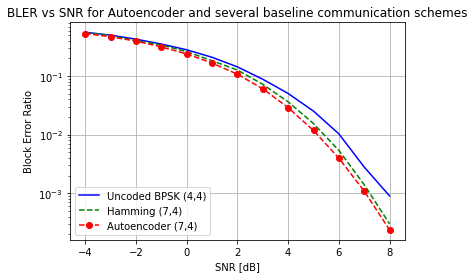

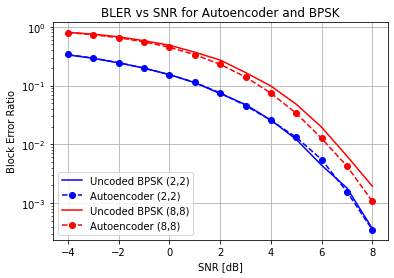

In [12]:
# File:   radio_autoencoder.py
# Brief:  Simulates a radio link over AWGN channel for Uncoded, Hamming 
#         coded and Neural network autoencoded radio links.
#         Reproduces the results obtained in 
#         "An Introduction to Deep Learning for the Physical Layer",
#         Timothy J. O'Shea, Jakob Hoydis
# Author: Vidit Saxena
#
# Usage:  python radio_autoencoder.py
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

#from src import uncoded, hamming
#from src import autoencoder

from matplotlib import pyplot as plt

''' Function:    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)
    Description: Block error ratio (BLER) vs Signal to Noise Ratio (SNR) 
                 curves for standard channel coding using Hamming codes, 
                 and for 'learnt' optimal representation that are obtained 
                 by training a neural network based autoencoder. Additive 
                 White Gaussian Noise (AWGN) channel is assumed. 
'''  
def _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db):
    
    channel_use = {4: 7} # Mapping to get length of Hamming codeblock from block length 
        
    '''BLER for uncoded BPSK over AWGN channel'''
    print('-------Evaluating BLER for Uncoded (%d,%d) over AWGN-------'%(block_size, block_size))
    bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]
     
    '''BLER for Hamming coded bits over AWGN channel'''
    print('-------Evaluating BLER for Hamming (%d,%d) over AWGN-------' %(channel_use[block_size], block_size))
    bler_hamming = [block_error_ratio_hamming_awgn(snr, block_size) for snr in snrs_db]
    
    '''BLER for Autoencoder coded bits over AWGN channel'''
    print('-------Evaluating BLER for Autoencoder (%d,%d) over AWGN-------' %(channel_use[block_size], block_size))
    batch_size = int(20/block_size)
    nrof_steps = int(200000/block_size)
    bler_autoenc = block_error_ratio_autoencoder_awgn(snrs_db, block_size, channel_use[block_size], batch_size, nrof_steps)
    
    print('-------Plotting results-------')
    plt.figure()
    plt.grid(True)
    plt.semilogy(snrs_db, bler_unc, ls = '-', c = 'b')
    plt.semilogy(snrs_db, bler_hamming, ls = '--', c = 'g')
    plt.semilogy(snrs_db, bler_autoenc, ls = '--', c = 'r', marker = 'o')
    plt.xlabel('SNR [dB]')
    plt.ylabel('Block Error Ratio')
    plt.legend(['Uncoded BPSK (%d,%d)'%(block_size, block_size), 
                'Hamming (%d,%d)'%(channel_use[block_size], block_size),
                'Autoencoder (%d,%d)'%(channel_use[block_size], block_size)],
               loc = 'lower left')
    plt.title('BLER vs SNR for Autoencoder and several baseline communication schemes')
    
    print (bler_unc)
    print(bler_hamming)
    print (bler_autoenc)
    return (bler_hamming, bler_autoenc)

''' Function:    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)
    Description: Block error ratio (BLER) vs Signal to Noise Ratio (SNR) curves 
                 for uncoded transmission, and for 'learnt' optimal 
                 representations of the transmitted bits that are obtained by 
                 training a neural network based autoencoder. Additive White 
                 Gaussian Noise (AWGN) channel is assumed. 
'''  
def _bler_vs_snr_uncoded_autoenc(block_sizes, snrs_db):
    
    plt.figure()
    plt.grid(True)
    legend_strings = []
    colors = iter(list(['b', 'r', 'g', 'b', 'm']))
    for block_size in block_sizes:
        '''BLER for uncoded bits over AWGN channel'''
        print('-------Evaluating BLER for Uncoded BPSK (%d,%d) over AWGN-------' %(block_size, block_size))
        bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]
    
        '''BLER for Autoencoder coded  bits over AWGN channel'''
        print('-------Evaluating BLER for Autoencoder (%d,%d) over AWGN-------' %(block_size, block_size))
        batch_size = 10/block_size
        nrof_steps = 100000/block_size
        bler_autoenc = block_error_ratio_autoencoder_awgn(snrs_db, block_size, block_size, batch_size, nrof_steps)
        
        print('-------Plotting results-------')
        color = next(colors) 
        plt.semilogy(snrs_db, bler_unc, ls = '-', c = color)
        plt.semilogy(snrs_db, bler_autoenc, ls = '--', c = color, marker = 'o')
        
        legend_strings.append('Uncoded BPSK (%d,%d)'%(block_size, block_size))
        legend_strings.append('Autoencoder (%d,%d)'%(block_size, block_size))

    plt.xlabel('SNR [dB]')
    plt.ylabel('Block Error Ratio')
    plt.legend(legend_strings, loc = 'lower left')
    plt.title('BLER vs SNR for Autoencoder and BPSK')
    
if __name__ == '__main__':
    snrs_db = range(-4, 9)
    
    '''BLER for block size 4 with Autoencoder and Hamming'''
    block_size = 4
    channel_use = 7
    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)

    '''BLER for block sizes 2 and 8 with uncoded and Autoencoder'''
    block_sizes = [2, 8]
    _bler_vs_snr_uncoded_autoenc(block_sizes, snrs_db)
    
    plt.show()